**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**July, 2023**



---

# Fine annotation of macrophages at 48hpi


In [1]:
#pip install episcanpy

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import anndata

import seaborn as sns 

import matplotlib.pyplot as plt
import matplotlib as mpl
import gc

In [5]:
#For TF-IDF
import episcanpy as epi
from sklearn.feature_extraction.text import TfidfTransformer

In [26]:
def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
bamnostic           NA
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
episcanpy           0.4.0
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
intervaltree        NA
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyte

'/opt/conda/bin/python'

In [3]:
def identityTransfer(adata_CellsNewID, adata, field='cell_type'):
    
    '''
    Function to transfer the value in a .obs column, modifying only the cells included in adata_CellsNewID
    
    Parameters:
        adata_CellsNewID: anndata object with cells. These should have in their .obs[field] the new values to be transfer to adata
        adata: anndata object to modify. The value in .obs[field] will be modifies for all the cells in adata_CellsNewID
        field: column name in .obs to operate in.
        
     Return:
        anndata object with the metadata modified
        
    '''
    
    #converting categorical into strings to introduce new categories
    adata.obs[field]=adata.obs[field].astype("string")


    #assigning the new categories to the cells in adata
    for cell in adata_CellsNewID.obs.index:
        adata.obs[field][cell] = adata_CellsNewID.obs[field][cell]

    #Returning strings into categorical 
    adata.obs[field]=adata.obs[field].astype("category")
    
    return(adata)

In [6]:
def runTF_IDF(adata, groupby, method='wilcoxon'):
    
    '''
    Function to run TF-IDF and DE analysis. TF-IDF means term-frequency times inverse document-frequency. 
    Its goal is to scale down the impact of tokens that occur very frequently (i.e. less informative)
    than features that occur in a small fraction of the training corpus.
    The the function applies a DE analysis.
    
    Parameters:
        adata: anndata object with cells.
        groupby: column name in .obs to make the DE comparison.
        method: method to use for Differential expression.
    
    Return:
        anndata object with the DE genes stored in adata.uns['rank_genes_groups']
        
    '''
    
    
    #counts = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)
    counts = anndata.AnnData(X=adata.X, var=adata.var, obs=adata.obs, asview=False)


    #-- Binarize counts matrix (1 if expressed, 0 otherwise)
    adata_bin = epi.pp.binarize(counts, copy=True)
    adata_bin.X.shape


    #-- Compute TF-IDF
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(adata_bin.X.T)
    adata_bin.X = tfidf.T
    adata_bin.X.shape


    #-- Compute Mann-Withney test with scanpy
    sc.tl.rank_genes_groups(adata_bin, groupby= groupby, use_raw=False, method=method)

    return(adata_bin)

In [7]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= '', fig_format='svg'):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    ax1.set_xlim(0, 100)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.'+fig_format, bbox_inches='tight',
                       dpi=300, orientation='landscape', format= fig_format, optimize=True)

## Loading data

In [8]:
adata= sc.read('../results/scVI/rna7_scVIintegrated_latent30_All_20230707.h5ad')


### Setting up color palette for future plots

In [9]:
sc.set_figure_params(figsize=(5,5))

In [10]:
#DF with the row names as the identity of the cells
colors_final_df = pd.DataFrame(index = np.unique(adata.obs['cell_type']))


#Assign each color per cell type under the column color

#colors_final_df.loc['SCT', 'color'] = '#f779a3'
colors_final_df.loc['VCT', 'color'] = '#b27ab4'
colors_final_df.loc['VCT_fusing', 'color'] = '#b53179'
colors_final_df.loc['VCT_p', 'color'] = '#993f98'
colors_final_df.loc['VCT_CCC', 'color'] = '#e2a7c8'

colors_final_df.loc['iEVT', 'color'] = '#0069b4'
colors_final_df.loc['EVT_1', 'color'] = '#009999'
colors_final_df.loc['EVT_2', 'color'] = '#03f9f2'


colors_final_df.loc['Endo_f', 'color'] = '#3f752d'
colors_final_df.loc['F', 'color'] = '#6bb300'
colors_final_df.loc['F_p', 'color'] = '#91A376'
colors_final_df.loc['F_sm', 'color'] = '#40C232'

colors_final_df.loc['PV', 'color'] = '#d6ff99'



colors_final_df.loc['HBC', 'color'] = '#db5669'
colors_final_df.loc['PAMM1', 'color'] = '#f7e55e'

colors_final_dict= colors_final_df.to_dict()['color']

In [11]:
adata

AnnData object with n_obs × n_vars = 54992 × 36601
    obs: 'sample', 'stage', 'hpi', 'infection', 'percent_mito', 'n_counts', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi', 'celltype_predictions', 'probabilities', 'scrublet_doublet', 'cell_type', 'souporcell_MFgenotype', 'MFgenotype', 'cell_type_broad', 'stage_perInfection', 'celltype-Stage', 'Tg_intracellular', 'celltype-Intracellular'
    var: 'gene_ids', 'feature_types', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'MFgenotype_colors', '_scvi', 'cell_type_broad_colors', 'cell_type_colors', 'celltype_p

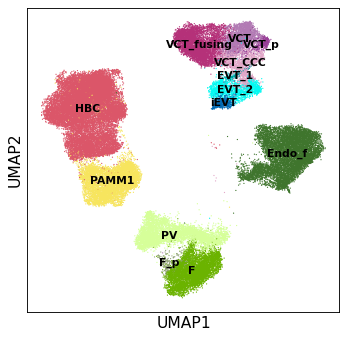

In [12]:
sc.pl.umap(adata, color=['cell_type'], size=5,
           palette= colors_final_dict, title='', legend_loc='on data',legend_fontsize='x-small')

### Subsetting Macrophages

In [13]:
#MPs = adata[adata.obs['identity'].isin(['HB','HB_inf','HB_p','PAMM1'])]

In [13]:
MPs = adata[adata.obs['cell_type'].isin(['HBC','PAMM1'])]

In [14]:
sc.pp.normalize_total(MPs, target_sum=1e4)
sc.pp.log1p(MPs)

normalizing counts per cell
    finished (0:00:00)


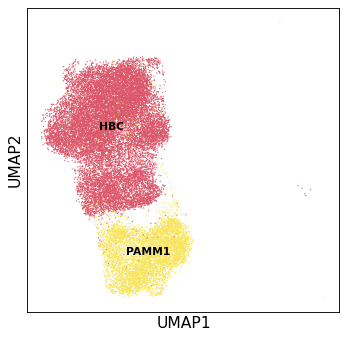

In [15]:
sc.pl.umap(MPs, color=['cell_type'], size=5,
           palette= colors_final_dict, title='', legend_loc='on data',legend_fontsize='x-small')

## Recalculate the UMAP coordinates

In [16]:
sc.set_figure_params(figsize=(4.5,4.5))

In [17]:
#LATENT 30
sc.pp.neighbors(MPs, n_neighbors=15, use_rep="X_scVI_n_latent_30")
sc.tl.umap(MPs)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_scvi', the cluster labels (adata.obs, categorical) (0:00:07)


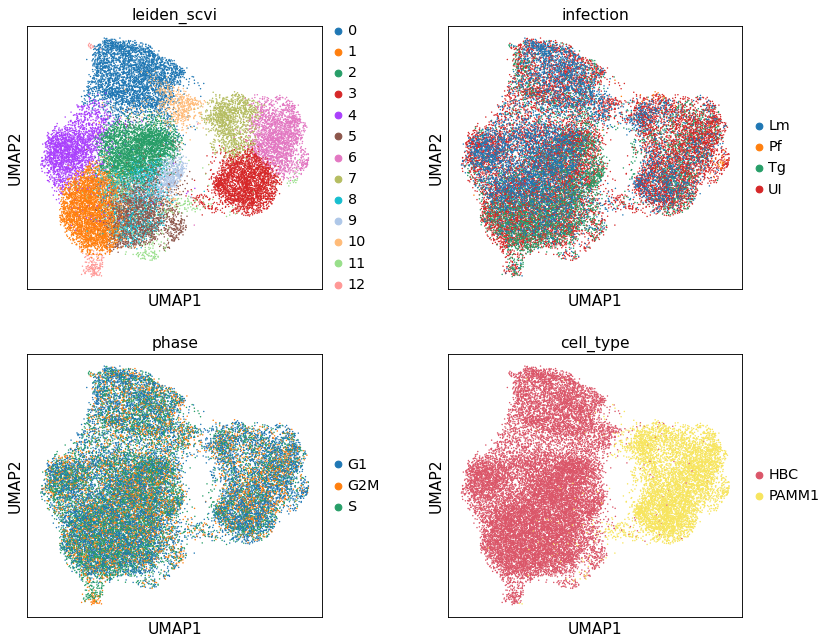

In [18]:
#clustering
sc.tl.leiden(MPs, key_added="leiden_scvi", resolution=0.9)


sc.pl.umap(MPs, color=["leiden_scvi",'infection','phase', 'cell_type',
                            ], ncols=2, wspace=0.3, size=7)

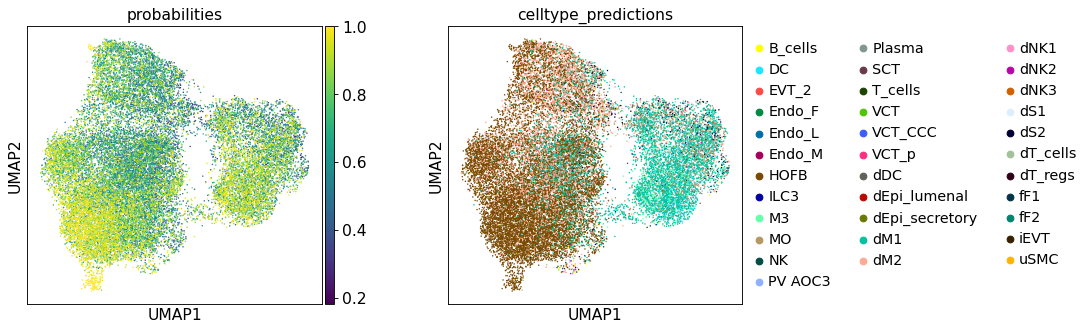

In [20]:
sc.pl.umap(MPs, color=[ 'probabilities','celltype_predictions'], ncols=2, wspace=0.3, size=7)

In [21]:
MPs

AnnData object with n_obs × n_vars = 24108 × 36601
    obs: 'sample', 'stage', 'hpi', 'infection', 'percent_mito', 'n_counts', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi', 'celltype_predictions', 'probabilities', 'scrublet_doublet', 'cell_type', 'souporcell_MFgenotype', 'MFgenotype', 'cell_type_broad', 'stage_perInfection', 'celltype-Stage', 'Tg_intracellular', 'celltype-Intracellular'
    var: 'gene_ids', 'feature_types', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'MFgenotype_colors', '_scvi', 'cell_type_colors', 'celltype_predictions_colors', 'donor

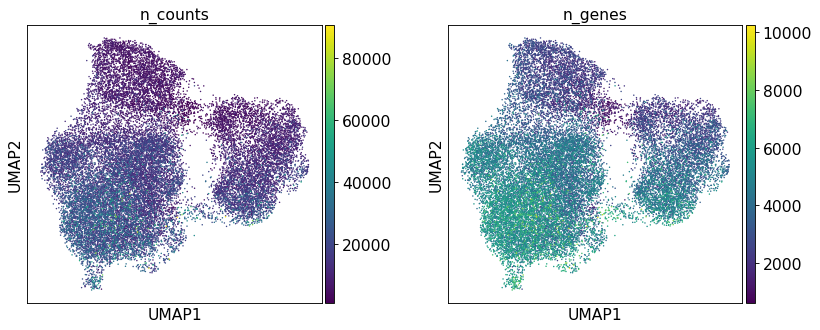

In [22]:
sc.pl.umap(MPs, color=['n_counts','n_genes'], ncols=3, wspace=0.3, size=7)

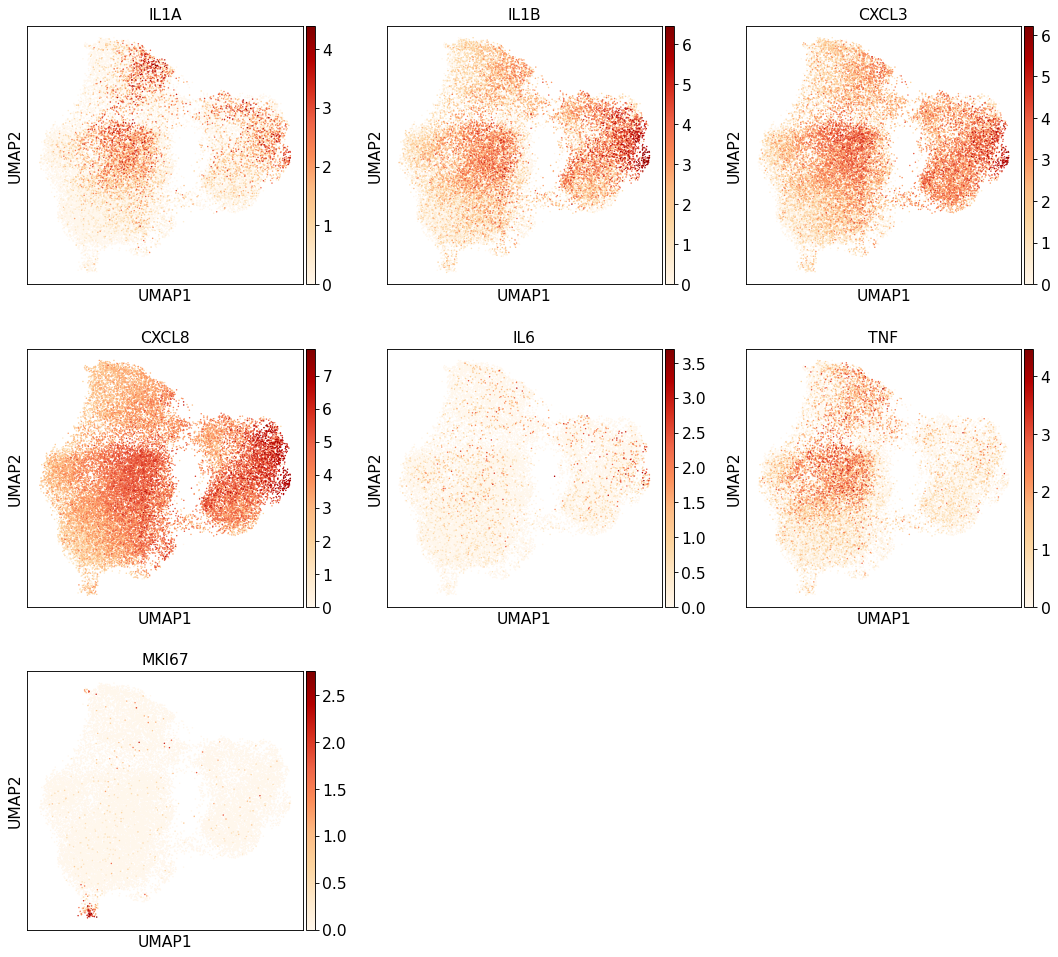

In [23]:
sc.pl.umap(MPs, color=[ 'IL1A','IL1B','CXCL3','CXCL8','IL6','TNF','MKI67'
                         ], color_map='OrRd', ncols=3, use_raw=False, size=7)

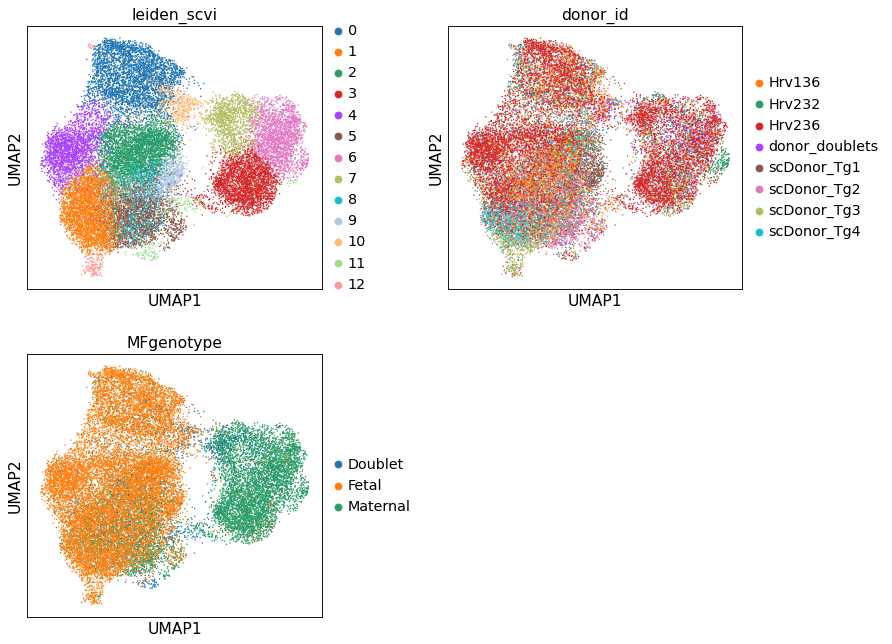

In [24]:
sc.pl.umap(MPs, color=["leiden_scvi",'donor_id','MFgenotype'], ncols=2, wspace=0.3, size=7)

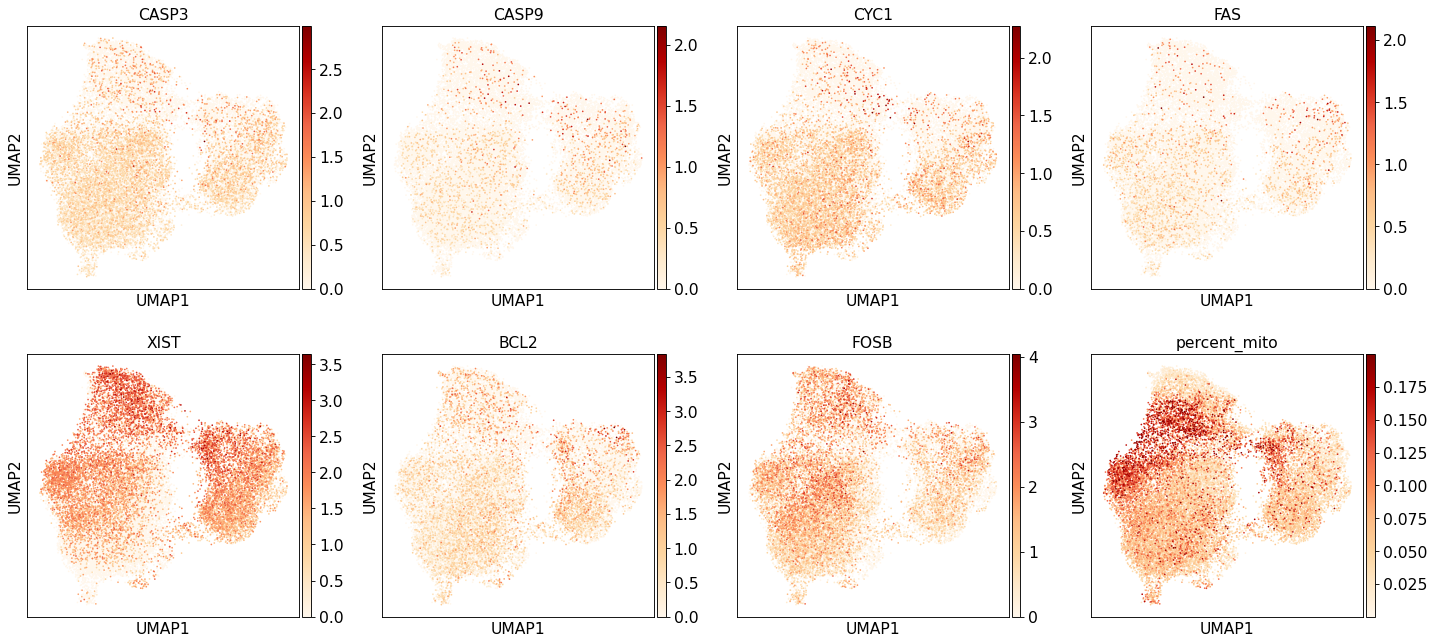

In [25]:
sc.pl.umap(MPs, color=['CASP3', 'CASP9', 'CYC1','FAS','XIST','BCL2','FOSB','percent_mito'],
           color_map='OrRd', size=9)

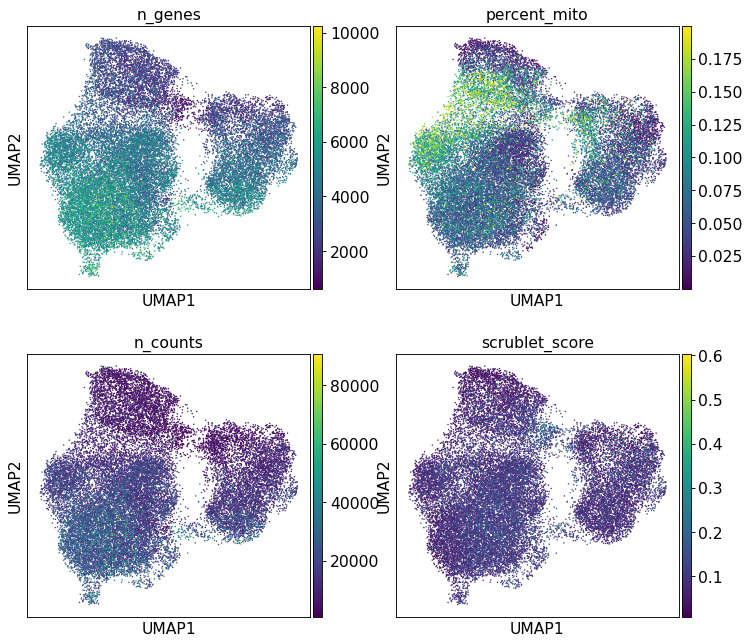

In [26]:
sc.pl.umap(MPs, color=["n_genes",'percent_mito','n_counts',
                         'scrublet_score' ], ncols=2, size=7)

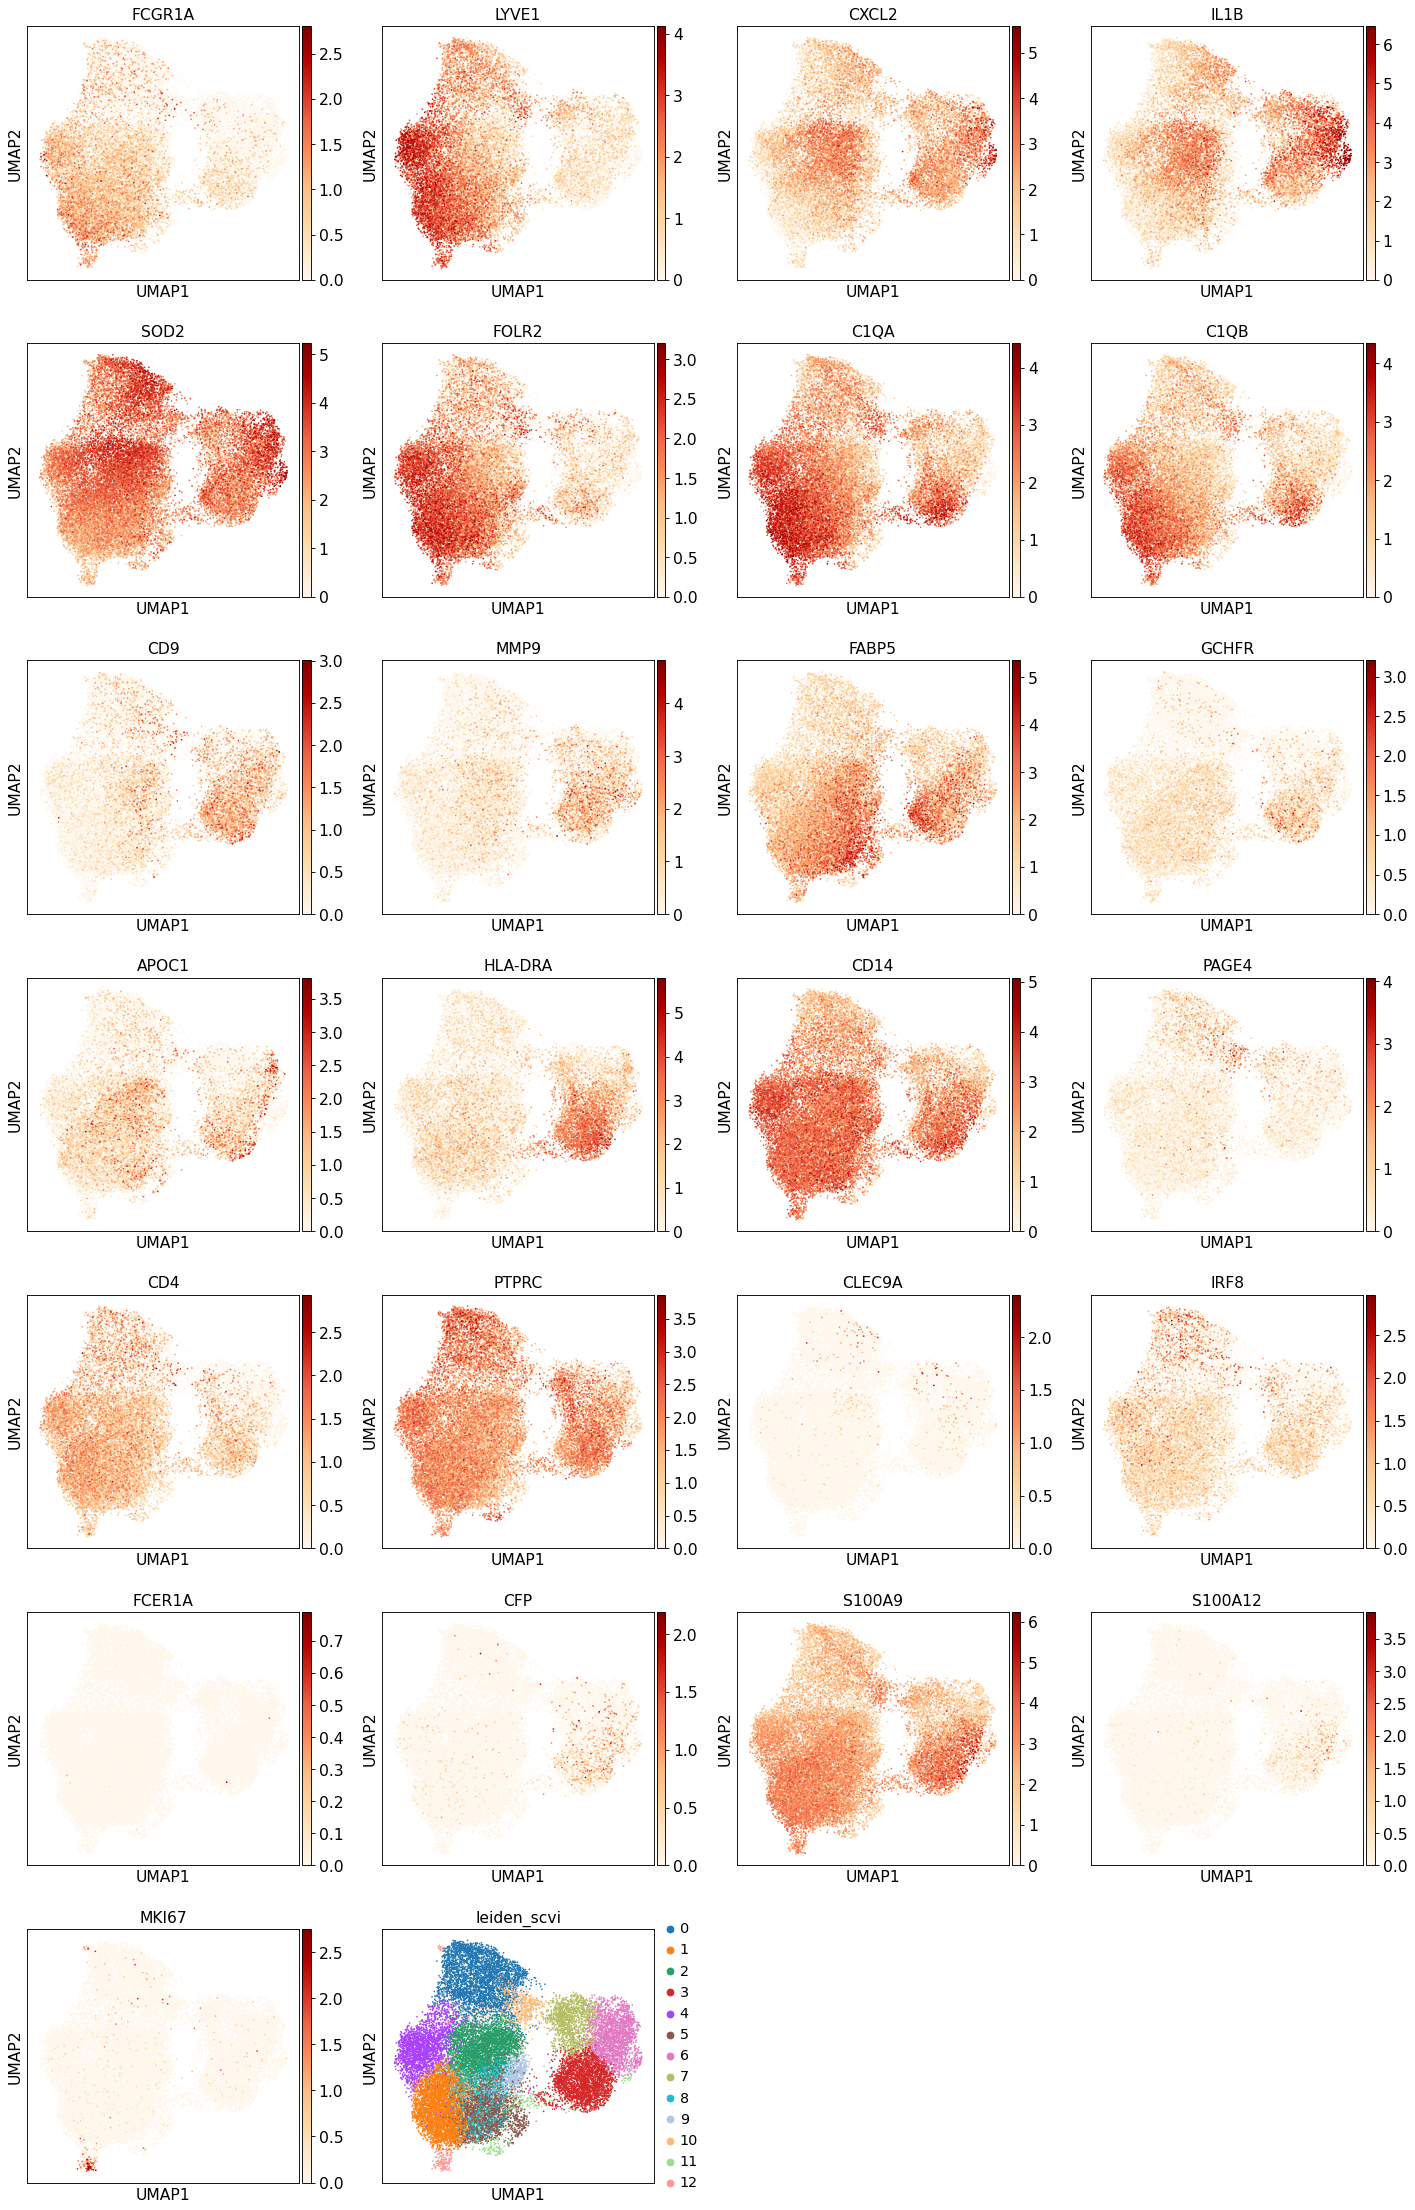

In [27]:
sc.pl.umap(MPs, color=['FCGR1A','LYVE1', #HB
                              'CXCL2', 'IL1B', 'SOD2', #dM1
                              'FOLR2', #HB & dM2
                              'C1QA','C1QB',#dM2
                              'CD9', 'MMP9','FABP5','GCHFR','APOC1','HLA-DRA',#M3
                              'CD14',
                              'PAGE4','CD4','PTPRC',
                              'CLEC9A','IRF8', #DC1
                              'FCER1A','CFP',#DC2
                              'S100A9','S100A12',#Mo
                              'MKI67',#HB_p
                              'leiden_scvi'],color_map='OrRd', size=9)

### TF-IDF of Macrophage clusters

In [28]:
MPs

AnnData object with n_obs × n_vars = 40202 × 36601
    obs: 'sample', 'stage', 'hpi', 'infection', 'percent_mito', 'n_counts', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi', 'celltype_predictions', 'probabilities', 'scrublet_doublet', 'cell_type_2022', 'cell_type', 'souporcell_MFgenotype', 'MFgenotype', 'cell_type_broad', 'umap_density_Tg_infected', 'stage_perInfection', 'celltype-Stage', 'Tg_intracellular', 'celltype-Intracellular'
    var: 'gene_ids', 'feature_types', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'MFgenotype_colors', '_scvi', 'cell_type_

In [29]:
#Adding the raw anndata object
#MPs.raw=adata[adata.obs['identity'].isin(['HBC','PAMM1'])].copy()

In [30]:
#Adding the raw anndata object
#MPs.raw=adata[adata.obs['identity'].isin(['HB','HB_inf','HB_p','PAMM1'])]
#adata[adata.obs['identity'].isin(['HB','PAMM1'])].copy()

In [28]:
MPs_TFidf= runTF_IDF(MPs, groupby='leiden_scvi', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:07)


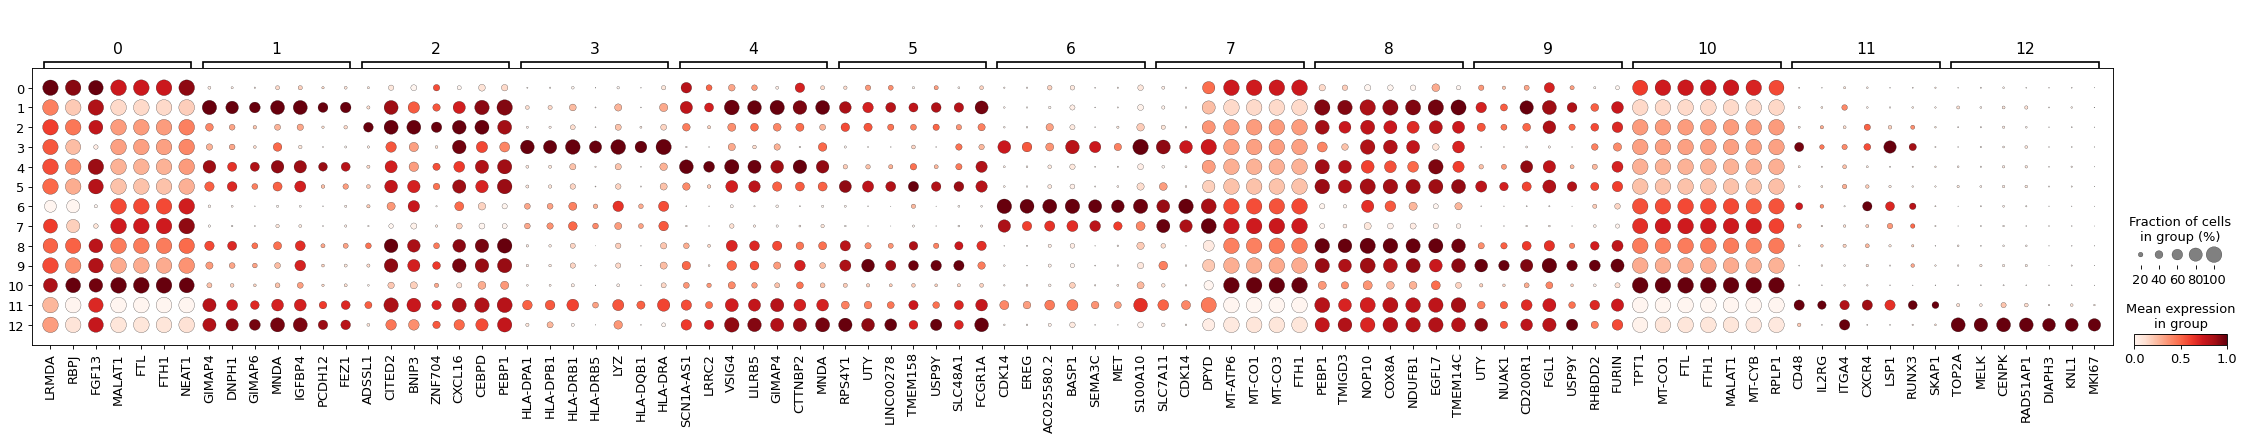

In [29]:
sc.pl.rank_genes_groups_dotplot(MPs_TFidf, n_genes=7, dendrogram=False,standard_scale='var')

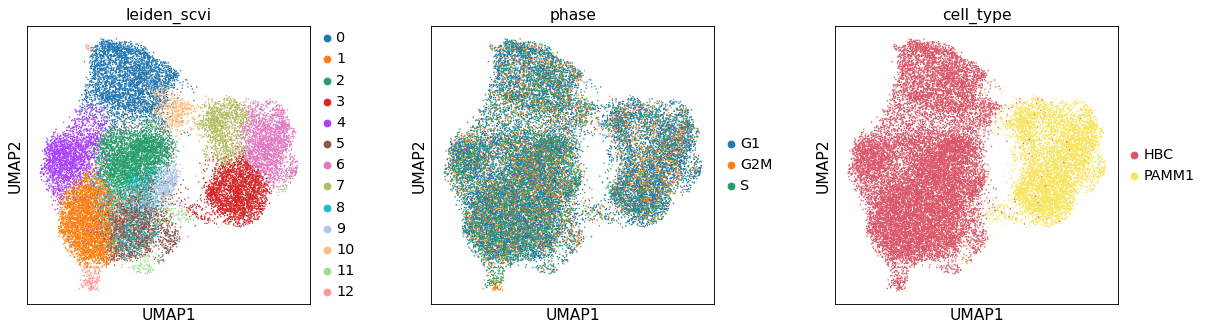

In [30]:
sc.pl.umap(MPs, color=["leiden_scvi",'phase', 'cell_type'], ncols=3, wspace=0.3, size=7)

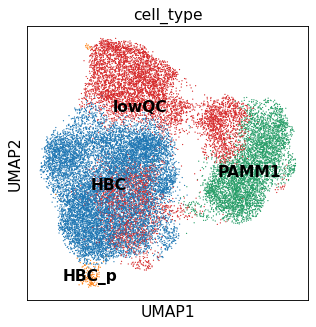

In [19]:
#COpying the value of the leiden cluster. The new column will help to change it's values for
# the cluster identity
MPs.obs['cell_type']= MPs.obs['leiden_scvi']


#Function that changes the cluster names as indicated
MPs.obs['cell_type'] = (MPs.obs["leiden_scvi"].map(lambda x: 
                            {"0": "lowQC","1": "HBC", "2": "HBC", "3": "PAMM1", "4": "HBC", "5": "HBC",
                            "6": "PAMM1", "7": "lowQC", "8": "lowQC", "9": "HBC","10": "lowQC", "11": "lowQC", "12": "HBC_p"}
                            .get(x, x)).astype("category"))


sc.pl.umap(MPs, color=['cell_type'], wspace=0.3, legend_loc='on data')

In [33]:
sc.settings.figdir = '../results/images/integrated/'

### Transferring annotation

In [20]:
adata= identityTransfer(MPs, adata)

In [21]:
adata = adata[adata.obs['cell_type'] != 'lowQC']
adata = adata[adata.obs['cell_type'] != 'doublets']

#removing missing doublets
adata = adata[adata.obs['MFgenotype'] != 'Doublet']
adata = adata[adata.obs['donor_id'] != 'donor_doublets']
adata = adata[adata.obs['scrublet_doublet'] != 'True']

# Checking the number of cells per donor

In [22]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_id'].values.describe()
#adata.obs['donor_souporcell'].values.describe()

Total number of cells: 45950
Total number of genes: 36601


counts     freqs
categories                   
Hrv136         5590  0.121654
Hrv232         2508  0.054581
Hrv236        13373  0.291034
scDonor_Tg1    4985  0.108487
scDonor_Tg2    5200  0.113166
scDonor_Tg3    6474  0.140892
scDonor_Tg4    7820  0.170185

# Re calculating the UMAP coordinates

In [23]:
#LATENT 30
sc.pp.neighbors(adata, n_neighbors=20, use_rep="X_scVI_n_latent_30")
sc.tl.umap(adata)

#clustering
sc.tl.leiden(adata, key_added="leiden_scvi", resolution=0.3)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_scvi', the cluster labels (adata.obs, categorical) (0:00:04)


In [27]:
#DF with the row names as the identity of the cells
colors_final_df = pd.DataFrame(index = np.unique(adata.obs['cell_type']))


#Assign each color per cell type under the column color
colors_final_df.loc['VCT', 'color'] = '#b27ab4'
colors_final_df.loc['VCT_fusing', 'color'] = '#b53179'
colors_final_df.loc['VCT_p', 'color'] = '#993f98'
colors_final_df.loc['VCT_CCC', 'color'] = '#e2a7c8'

colors_final_df.loc['iEVT', 'color'] = '#0069b4'
colors_final_df.loc['EVT_1', 'color'] = '#009999'
colors_final_df.loc['EVT_2', 'color'] = '#03f9f2'


colors_final_df.loc['Endo_f', 'color'] = '#3f752d'
colors_final_df.loc['F', 'color'] = '#6bb300'
colors_final_df.loc['F_p', 'color'] = '#91A376'
colors_final_df.loc['F_sm', 'color'] = '#40C232'

colors_final_df.loc['PV', 'color'] = '#d6ff99'



colors_final_df.loc['HBC', 'color'] = '#db5669'
colors_final_df.loc['HBC_p', 'color'] = '#7d303c'


colors_final_df.loc['PAMM1', 'color'] = '#f7e55e'

colors_final_dict= colors_final_df.to_dict()['color']

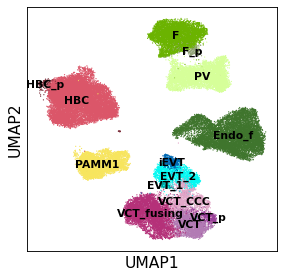

In [28]:
sc.pl.umap(adata, color=['cell_type'], size=5,
           palette= colors_final_dict, title='', legend_loc='on data', legend_fontsize='x-small')

In [49]:
#adata.write('../results/scVI/rna8_scVIintegrated_latent30_All_20230707.h5ad')

In [50]:
del(adata.raw)

In [51]:
adata.obs['celltype-Intracellular']

Pla_HDBR13007974_AAACCCAAGCGTTGTT             F-UI_Tg_24h
Pla_HDBR13007974_AAACCCAAGTAGTCAA    VCT_fusing-UI_Tg_24h
Pla_HDBR13007974_AAACCCACAATGAACA           HBC-UI_Tg_24h
Pla_HDBR13007974_AAACCCACAGAGAGGG           HBC-UI_Tg_24h
Pla_HDBR13007974_AAACCCACAGTAGAAT           HBC-UI_Tg_24h
                                             ...         
Pla_HDBR13661572_TTTGTTGAGGTTCATC              HBC-Lm_24h
Pla_HDBR13661572_TTTGTTGCAAATTAGG           Endo_f-Lm_24h
Pla_HDBR13661572_TTTGTTGCAATAGGGC                F-Lm_24h
Pla_HDBR13661572_TTTGTTGGTGCTTATG           Endo_f-Lm_24h
Pla_HDBR13661572_TTTGTTGGTGGTAACG            PAMM1-Lm_24h
Name: celltype-Intracellular, Length: 113028, dtype: category
Categories (82, object): ['EVT_1-Lm_24h', 'EVT_1-No_intracellular-Tg', 'EVT_1-Pf_24h', 'EVT_1-UI_Lm_24h', ..., 'iEVT-Pf_24h', 'iEVT-UI_Lm_24h', 'iEVT-UI_Pf_24h', 'iEVT-UI_Tg_24h']

# Adding the developmental stage

In [30]:
adata.obs['donor_id'].values.describe()

counts     freqs
categories                   
Hrv136         5590  0.121654
Hrv232         2508  0.054581
Hrv236        13373  0.291034
scDonor_Tg1    4985  0.108487
scDonor_Tg2    5200  0.113166
scDonor_Tg3    6474  0.140892
scDonor_Tg4    7820  0.170185

In [31]:
#COpying the value of the leiden cluster. The new column will help to change it's values for
# the cluster identity
adata.obs['Dev_Stage']= adata.obs['donor_id']


#Function that changes the cluster names as indicated
adata.obs['Dev_Stage'] = (adata.obs["donor_id"].map(lambda x: 
                            {'Hrv136':'9pcw','Hrv232':'12pcw', 'Hrv236':'14pcw',
                            'scDonor_Tg1':'CS22', 'scDonor_Tg2':'12pcw','scDonor_Tg3':'CS23','scDonor_Tg4':'13pcw',}
                            .get(x, x)).astype("category"))

adata.obs['Dev_Stage'].cat.reorder_categories(['CS22','CS23','9pcw','12pcw','13pcw','14pcw'], inplace = True)



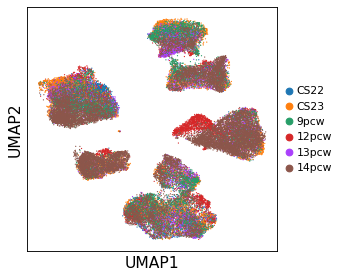

In [32]:
sc.pl.umap(adata, color=['Dev_Stage'], size=5,
            title='', legend_fontsize='x-small')

### Category concatenating the indentity + infections + day

In [33]:
adata.obs['celltype-Stage']= adata.obs.cell_type.astype('string')+'-'+adata.obs.stage_perInfection.astype('string')

### Saving the data

In [34]:
adata.X= adata.layers['raw_counts'].copy()

In [35]:
adata.write('../results/scVI/rna8_scVIintegrated_latent30_All_20230707_48h.h5ad')

... storing 'celltype-Stage' as categorical


In [36]:
adata.write('/nfs/team292/er13/PlacInfection_revision/results/scVI/rna8_scVIintegrated_latent30_All_20230707_48h.h5ad')